# Dependencies

In [ ]:
!pip install qdrant-client sentence-transformers pandas requests fastembed -q

import pandas as pd
import numpy as np
import uuid
import random
from qdrant_client import QdrantClient
from qdrant_client.models import PointStruct, VectorParams, Distance
from sentence_transformers import SentenceTransformer

: 

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
import pandas as pd
import random

file_path = "/content/drive/MyDrive/VectorsInOrbitCompetition/RailIncidentData.csv"

# Load Data
df_real = pd.read_csv(file_path, on_bad_lines='skip', low_memory=False, encoding='latin1')

# Clean
narrative_cols = [c for c in df_real.columns if "NARR" in c]
df_real['Full_Description'] = df_real[narrative_cols].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)

# Removing columns we don't need n empty cells
df_clean = df_real[['Full_Description', 'WEATHER', 'TRNSPD', 'ACCDMG']].copy()
df_clean = df_clean[df_clean['Full_Description'].str.strip() != ""]
df_clean = df_clean.head(500)

# Random solutions generated for insertion
strategies = [
    {"action": "REVERSE_MANEUVER", "desc": "Initiated retrograde movement to nearest switch.", "base_delay": 45},
    {"action": "REROUTE_FAST_TRACK", "desc": "Diverted following traffic to High-Speed Line B.", "base_delay": 10},
    {"action": "SINGLE_LINE_WORKING", "desc": "Established bidirectional flow on remaining open track.", "base_delay": 25},
    {"action": "BUS_BRIDGE", "desc": "Track impassable. Deployed emergency bus fleet.", "base_delay": 120}
]

def generate_resolution(row):
    damage = row['ACCDMG'] if pd.notnull(row['ACCDMG']) else 0
    full_text = str(row['Full_Description']).upper()

    if damage > 100000:
        sol = strategies[3]
    elif "DERAILED" in full_text or "DERAIL" in full_text:
        sol = strategies[2]
    elif "SWITCH" in full_text:
        sol = strategies[0]
    else:
        sol = random.choice(strategies)

    return pd.Series([
        sol['action'],
        sol['desc'],
        sol['base_delay'],
        random.randint(1, 50),
        random.choice(["Model-5", "Model-7", "Freight-X"]),
        f"Track-{random.randint(1, 10)}"
    ])

new_cols = ['Resolution_Action', 'Resolution_Detail', 'Avg_Delay', 'Times_Used', 'Train_Model', 'Track_ID']
df_clean[new_cols] = df_clean.apply(generate_resolution, axis=1)

print(f"✅ Ready! Created {len(df_clean)} Hybrid Records.")

✅ Ready! Created 500 Hybrid Records.


In [6]:
# @title 2.1 Inspecting Columns & Raw Stats

# 1. Show all columns in the original FRA dataset
print(f"📊 Total Columns in Raw Dataset: {len(df_real.columns)}")
print("📋 All Raw Columns (Sample):", df_real.columns.tolist()[:15], "...")

# 2. Show the specific columns selected for the Hybrid Memory
selected_cols = ['Full_Description', 'WEATHER', 'TRNSPD', 'ACCDMG']
print(f"\n🎯 Columns Selected for AI Memory: {selected_cols}")

# 3. Show statistical summary of the selected numeric columns
print("\n📈 Statistical Summary of Selected Data:")
# We include 'ACCDMG' (Damage Cost) and 'TRNSPD' (Train Speed)
display(df_clean[['TRNSPD', 'ACCDMG']].describe().round(2))

# Check for missing values in our selection
print("\n🔍 Data Completeness Check:")
print(df_clean[selected_cols].isnull().sum())

📊 Total Columns in Raw Dataset: 146
📋 All Raw Columns (Sample): ['IYR', 'IMO', 'RAILROAD', 'INCDTNO', 'IYR2', 'IMO2', 'RR2', 'INCDTNO2', 'IYR3', 'IMO3', 'RR3', 'INCDTNO3', 'DUMMY1', 'GXID', 'YEAR'] ...

🎯 Columns Selected for AI Memory: ['Full_Description', 'WEATHER', 'TRNSPD', 'ACCDMG']

📈 Statistical Summary of Selected Data:


,TRNSPD,ACCDMG
count,500.00,500.00
mean,12.17,173221.00
std,17.85,391876.46
min,0.00,0.00
25%,2.75,19978.00
50%,5.00,39795.00
75%,10.00,123172.75
max,79.00,3276546.00



🔍 Data Completeness Check:
Full_Description    0
WEATHER             0
TRNSPD              0
ACCDMG              0
dtype: int64


# Dataset stats

/tmp/ipython-input-1507305943.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0], data=df_clean, x='WEATHER', palette='Blues_d')


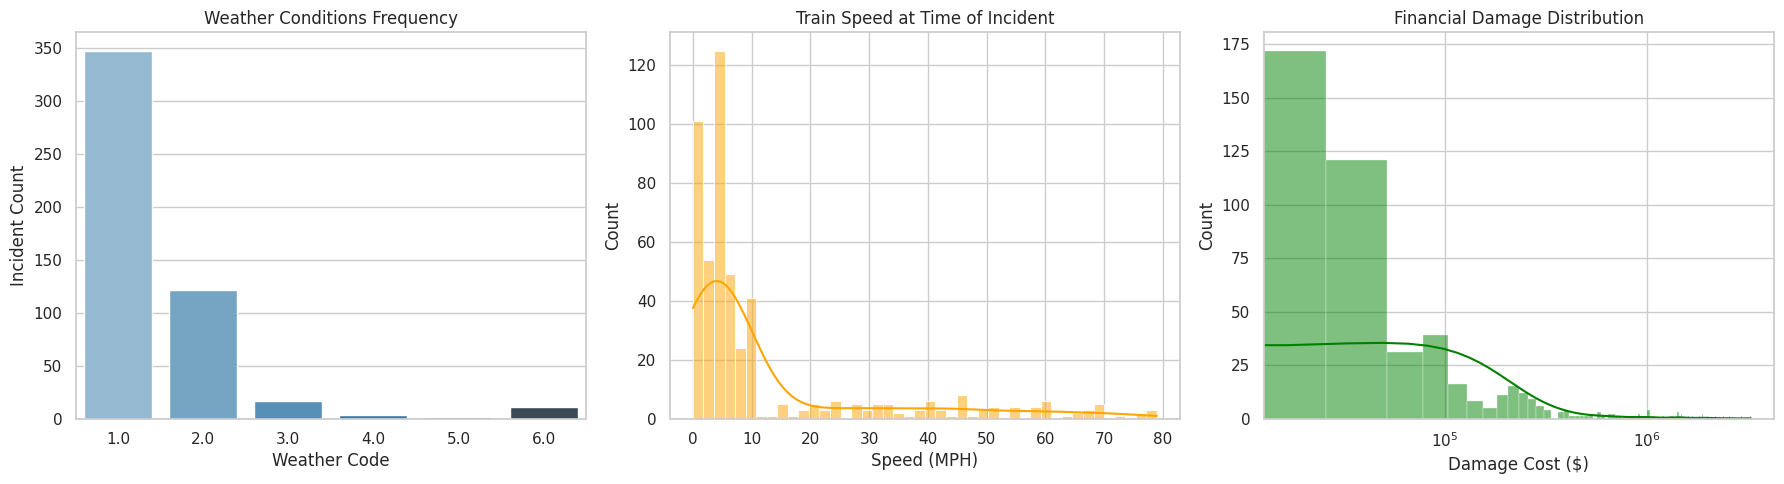

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set aesthetic style
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Weather Distribution
# Note: Weather codes 1=Clear, 2=Cloudy, 3=Rain, 4=Snow, 5=Fog, 6=Sleet
sns.countplot(ax=axes[0], data=df_clean, x='WEATHER', palette='Blues_d')
axes[0].set_title('Weather Conditions Frequency')
axes[0].set_xlabel('Weather Code')
axes[0].set_ylabel('Incident Count')

# Plot 2: Train Speed Distribution
sns.histplot(ax=axes[1], data=df_clean, x='TRNSPD', kde=True, color='orange')
axes[1].set_title('Train Speed at Time of Incident')
axes[1].set_xlabel('Speed (MPH)')

# Plot 3: Accident Damage (Log Scale for readability)
sns.histplot(ax=axes[2], data=df_clean, x='ACCDMG', kde=True, color='green')
axes[2].set_title('Financial Damage Distribution')
axes[2].set_xlabel('Damage Cost ($)')
axes[2].set_xscale('log') # Costs range from $100 to $1M+, so log scale is best

plt.tight_layout()
plt.show()

# Incident Stats



/tmp/ipython-input-1548754344.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clean, x='Resolution_Action', palette='viridis')


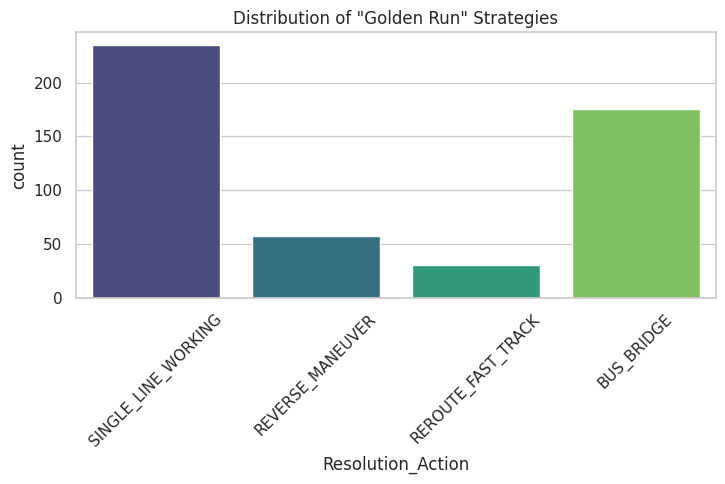


📊 DATABASE SUMMARY STATISTICS
       Avg_Delay      ACCDMG  Times_Used
count     500.00      500.00      500.00
mean       59.83   173221.00       26.17
std        45.03   391876.46       14.78
min        10.00        0.00        1.00
25%        25.00    19978.00       13.75
50%        25.00    39795.00       27.00
75%       120.00   123172.75       40.00
max       120.00  3276546.00       50.00


In [8]:
plt.figure(figsize=(14, 5))

# Distribution of Strategies
plt.subplot(1, 2, 1)
sns.countplot(data=df_clean, x='Resolution_Action', palette='viridis')
plt.title('Distribution of "Golden Run" Strategies')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("\n📊 DATABASE SUMMARY STATISTICS")
print(df_clean[['Avg_Delay', 'ACCDMG', 'Times_Used']].describe().round(2))

# Upload to Quadrant

In [9]:
client = QdrantClient(":memory:", embedding_model=None)
collection_name = "rail_hybrid_memory"
encoder = SentenceTransformer('all-MiniLM-L6-v2')

if not client.collection_exists(collection_name):
    client.create_collection(
        collection_name=collection_name,
        vectors_config=VectorParams(size=384, distance=Distance.COSINE),
    )

print("🧠 Learning Real-World Incidents... (Encoding Vectors)")

points = []
for idx, row in df_clean.iterrows():
    text_to_embed = f"{row['Full_Description']} | Weather: {row['WEATHER']}"
    vector = encoder.encode(text_to_embed).tolist()

    payload = {
        "original_log": row['Full_Description'],
        "resolution_action": row['Resolution_Action'],
        "resolution_detail": row['Resolution_Detail'],
        "statistics": {
            "avg_delay_mins": float(row['Avg_Delay']),
            "times_used": int(row['Times_Used']),
            "total_delay_accumulated": float(row['Avg_Delay'] * row['Times_Used'])
        },
        "constraints": {
            "train_model": row['Train_Model'],
            "track_id": row['Track_ID'],
            "is_track_functional": True # Initial state
        }
    }

    points.append(PointStruct(id=idx, vector=vector, payload=payload))

# Upload
client.upsert(collection_name=collection_name, points=points)
print(f"🚀 Success! {len(points)} Real-World Scenarios indexed with Golden Resolutions.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

🧠 Learning Real-World Incidents... (Encoding Vectors)
🚀 Success! 500 Real-World Scenarios indexed with Golden Resolutions.


# Test

In [10]:
import time

live_report = "Train 404 struck debris on track, front coupler damaged, light snow."

print(f"🚨 LIVE REPORT: {live_report}")
print("Searching...\n")

# Manual time calc
start_time = time.time()

query_vector = encoder.encode(live_report).tolist()

response = client.query_points(
    collection_name=collection_name,
    query=query_vector,
    limit=3
)

latency_ms = (time.time() - start_time) * 1000

print(f"Time taken {latency_ms:.2f}ms")
print(f"Found {len(response.points)} matching strategies:\n")

for i, hit in enumerate(response.points):
    p = hit.payload
    stats = p.get('statistics', {})

    print(f"{i+1}. MATCH: {p['resolution_action']} (Score: {hit.score:.3f})")
    print(f"   📜 HISTORY: {p['original_log'][:100]}...")
    print(f"   📊 PERFORMANCE: Used {stats.get('times_used')}x | Avg Delay: {stats.get('avg_delay_mins')}m")
    print(f"   ⚙️  EXECUTION: {p['resolution_detail']}")
    print("-" * 60)

🚨 LIVE REPORT: Train 404 struck debris on track, front coupler damaged, light snow.
Searching...

Time taken 26.94ms
Found 3 matching strategies:

1. MATCH: SINGLE_LINE_WORKING (Score: 0.600)
   📜 HISTORY: 267 YDM10R-28, WHILE SHOVING TO A JOINT IN TRACK 10 AT THE EAST END OF SHORTLINE YARD, WITH 2 ENGINE...
   📊 PERFORMANCE: Used 44x | Avg Delay: 25.0m
   ⚙️  EXECUTION: Established bidirectional flow on remaining open track.
------------------------------------------------------------
2. MATCH: REVERSE_MANEUVER (Score: 0.597)
   📜 HISTORY: 102 TRAIN 416 HIT A TREE THAT WAS ACROSS BOTH TRACKS. PRELIM DAMAGE REPORT RC''VD 3.9.22 FINAL D.R. ...
   📊 PERFORMANCE: Used 24x | Avg Delay: 45.0m
   ⚙️  EXECUTION: Initiated retrograde movement to nearest switch.
------------------------------------------------------------
3. MATCH: BUS_BRIDGE (Score: 0.591)
   📜 HISTORY: 168 Y-AMA2022-07A DERAILED 11 RAILCARS ON YARD TRACK AFTER THE TRAIN SEPARATED AND THEN MADE IMPACT ...
   📊 PERFORMANCE: Use